此代码是为了调查对于帕累托前沿中的支配点的TIMs与任务表现的关系

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import pickle
from dataclasses import dataclass


In [57]:
# 数据提取，任务数据
# 数据保存在saved_studies/ParetoFront_CQandMC文件夹下
path1 = r"C:\Users\Chen\Desktop\Repository\spnc_taskindependent_metrics\saved_studies\ParetoFront_CQandMC\CQ_MC_Pareto_beta50_20250825_121711_dominatedpoints.csv"


data_task = pd.read_csv(path1)

nrmse = data_task["narma10_nrmse"]
error_rate = (1-data_task["ti46_accuracy"])*100

path2 = r"C:\Users\Chen\Desktop\Repository\spnc_taskindependent_metrics\saved_studies\CQ_MC_Pareto_beta50_20250825_121711_dominatedpoints.csv"

data_MC = pd.read_csv(path2)
MC = data_MC["values"].apply(lambda x: ast.literal_eval(x)[1])
# 从pkl文件中读取数据
import pickle

@dataclass
class TaskResults:
    """Stores KR/GR evaluation results for a trial with normalization method."""
    trial_number: int
    gamma: float
    theta: float
    m0: float
    beta_prime: float
    normalization_method: str
    sKR: np.ndarray
    sGR: np.ndarray

# 数据提取，TIMs数据
file_path = r"C:\Users\Chen\Desktop\Repository\spnc_taskindependent_metrics\ParetoFront_CQandMC\ParetoFront_CQ_MC_Pareto_beta50_20250825_121711_dominatedpoints_returnsKRsGR.pkl"

with open(file_path, "rb") as f:
    data_tims = pickle.load(f)

# list的长度为160


In [40]:
def calculate_KR_GR(sKR, sGR, threshold,Nreadouts=200):
    KR = 0
    GR = 0
    for i in range(Nreadouts):
        if sGR[i]>threshold:
            GR += 1
        if sKR[i]>threshold:
            KR += 1
    return KR, GR

thresholds =np.logspace(np.log10(0.001), np.log10(0.1), 30)

labels = [
    ('max', 0, 'o', 'C0'),
    ('-1/1', 1, 's', 'C1'),
    ('0/1', 2, '^', 'C3'),
    ('without', 3, '*', 'C2'),
]
import os

def plot_cq_vs_thresholds(labels, data, thresholds, quiet=True, outdir='normalizedandthreshold/beta50_theta02_maxth0001'):
    """
    Plot CQ vs thresholds for different normalization/label sets.

    Parameters:
    labels : list of (name, idx, marker, color)
    data : list-like, each element has .sKR and .sGR arrays
    thresholds : iterable of threshold values
    quiet : bool, if True: do not show, only save figure.
            if False: show and save figure.
    outdir : str, output directory
    """
    # Prepare results for plotting
    cq_results = {}
    for name, idx, marker, color in labels:
        KR, GR = [], []
        for t in thresholds:
            kr, gr = calculate_KR_GR(data[idx].sKR, data[idx].sGR, t)
            KR.append(kr)
            GR.append(gr)
        CQ = np.array(KR) - np.array(GR)
        cq_results[name] = dict(CQ=CQ, marker=marker, color=color)

    plt.figure(figsize=(6, 5))

    for name, props in cq_results.items():
        plt.scatter(thresholds, props['CQ'], s=70, marker=props['marker'], color=props['color'], label=name)

    plt.xlabel('threshold')
    plt.ylabel('CQ')
    plt.xscale('log')
    plt.legend()

    # Ensure output dir exists
    os.makedirs(outdir, exist_ok=True)

    # Build filename based on index in labels if possible
    try:
        group_ids = "_".join([str(idx) for (_, idx, _, _) in labels])
        filename = f"CQ_vs_thresholds_{group_ids}.png"
    except Exception:
        filename = "CQ_vs_thresholds.png"
    outpath = os.path.join(outdir, filename)

    plt.savefig(outpath, bbox_inches='tight', dpi=200)
    if not quiet:
        plt.show()
    else:
        plt.close()


# 调用函数
plot_cq_vs_thresholds(labels, data_tims, thresholds)



In [41]:
# 可以用遍历和结构化批量处理
# 更加优雅且可维护的自动生成方式
start, end, group_size = 0, 159, 4
group_indices = [list(range(i, i+group_size)) for i in range(start, end+1, group_size)]
for indices in group_indices:
    labels = [
        ('max',     indices[0], 'o', 'C0'),
        ('-1/1',    indices[1], 's', 'C1'),
        ('0/1',     indices[2], '^', 'C3'),
        ('without', indices[3], '*', 'C2'),
    ]
    plot_cq_vs_thresholds(labels, data_tims, thresholds,outdir='normalizedandthreshold/beta50_theta02_maxth01_dominatedpoints')

In [43]:
def get_CQ_by_type_and_threshold(idx_within_group, threshold):
    """
    提取每4条中的第idx_within_group条，指定threshold，返回一个dict，key为归一化方法名称，value为CQ值的pd.Series
    """
    file_path = r"C:\Users\Chen\Desktop\Repository\spnc_taskindependent_metrics\ParetoFront_CQandMC\ParetoFront_CQ_MC_Pareto_beta50_20250825_121711_dominatedpoints_returnsKRsGR.pkl"
    with open(file_path, "rb") as f:
        CQ_data = pickle.load(f)
    
    # 假设归一化方法顺序与idx一致（需根据实际情况调整）
    normalization_methods = ["max", "-1/1", "0/1", "without"]
    
    result = {}
    for method_i in range(len(normalization_methods)):
        indices = range(method_i, len(CQ_data), 4)
        if method_i == idx_within_group:
            CQ = pd.Series(
                calculate_KR_GR(trial.sKR, trial.sGR, threshold)[0] - calculate_KR_GR(trial.sKR, trial.sGR, threshold)[1]
                for trial in (CQ_data[i] for i in indices)
            )
            # 用dict来保存信息，更加方便调用
            result = {
                "CQ": CQ,
                "method_label": normalization_methods[method_i],
                "threshold": threshold
            }
    return result

In [52]:
CQ = get_CQ_by_type_and_threshold(2, 0.003)

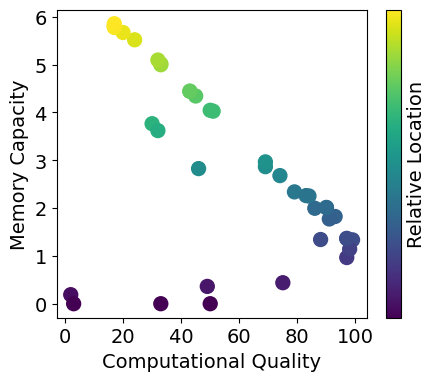

In [53]:
plt.figure(figsize=(5, 4))
plt.scatter(CQ['CQ'], MC, c=MC, cmap='viridis', s=100)
cbar = plt.colorbar(label='Relative Location', ticks=[])
cbar.set_label('Relative Location', fontsize=14)
plt.xlabel('Computational Quality', fontsize=14)
plt.ylabel('Memory Capacity', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [54]:
# 遍历不同的normalization方法和threshold，获得一个dict,存储由get_CQ_by_type_and_threshold得到的信息
normalization_methods = [0,1,2,3]
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
result = {}
for method in normalization_methods:
    for threshold in thresholds:
        CQ = get_CQ_by_type_and_threshold(method, threshold)
        result[method, threshold] = CQ

In [55]:
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
print(thresholds)
# 从thresholds中按照等间距取5个点，需要包含最大值和最小值
# 从thresholds中等间距选取5个点（包括首尾），保证取值在thresholds内
indices = np.linspace(0, len(thresholds) - 1, 5, dtype=int)
thresholds_5 = thresholds[indices]
print(thresholds_5)

[0.001      0.0011721  0.00137382 0.00161026 0.00188739 0.00221222
 0.00259294 0.0030392  0.00356225 0.00417532 0.0048939  0.00573615
 0.00672336 0.00788046 0.00923671 0.01082637 0.01268961 0.01487352
 0.01743329 0.0204336  0.02395027 0.02807216 0.03290345 0.0385662
 0.04520354 0.05298317 0.06210169 0.07278954 0.08531679 0.1       ]
[0.001      0.0030392  0.00923671 0.02807216 0.1       ]


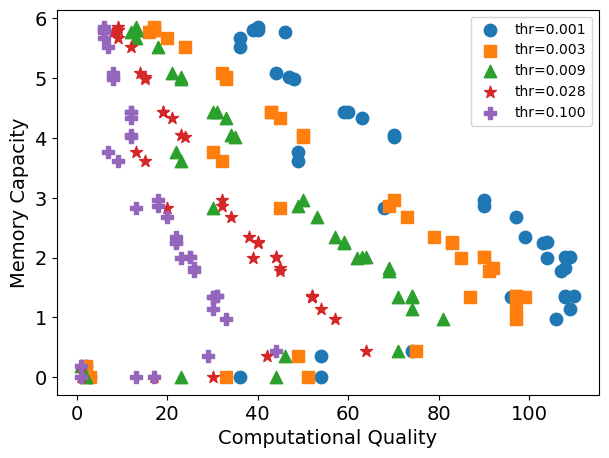

In [62]:
#绘制不同threshold下，0/1归一化方法的CQ与MC的散点图
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
indices = np.linspace(0, len(thresholds) - 1, 5, dtype=int)
selected_thresholds = thresholds[indices]
# 提前设定不同的marker
markers = ['o', 's', '^', '*', 'P']
# 提前设定不同的颜色
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.figure(figsize=(7, 5))
for th, marker, color in zip(selected_thresholds, markers, colors):
    plt.scatter(result[2, th]['CQ'], MC, marker=marker, s=80, color=color, label=f'thr={th:.3f}')   
plt.xlabel('Computational Quality', fontsize=14)
plt.ylabel('Memory Capacity', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

C:\Users\Chen\AppData\Local\Temp\ipykernel_9280\711276313.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # 避免colorbar重叠


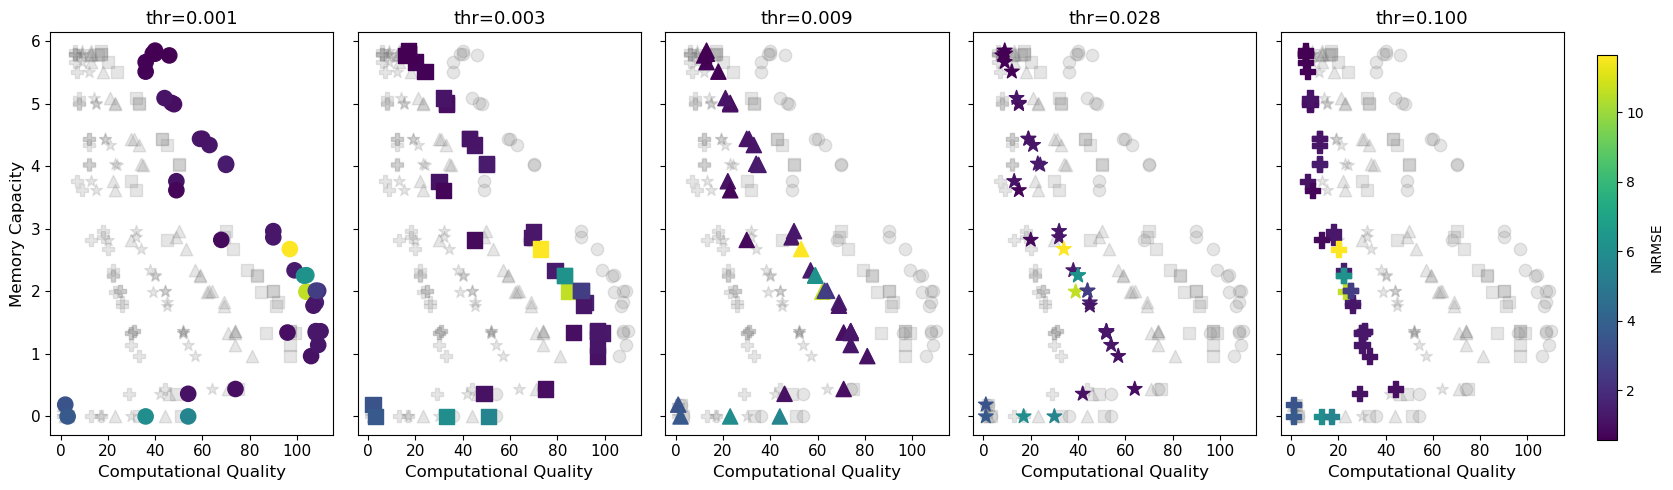

In [63]:
# 将不同threshold的0/1散点图绘制为2*3的子图，最后一个子图用于放colorbar
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
indices = np.linspace(0, len(thresholds) - 1, 5, dtype=int)
selected_thresholds = thresholds[indices]
# 提前设定不同的marker
markers = ['o', 's', '^', '*', 'P']
# 提前设定不同的颜色
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
axes_flat = axes.flatten()
sc = None

for i, (th_cur, marker_cur, color_cur) in enumerate(zip(selected_thresholds, markers, colors)):
    ax = axes_flat[i]
    # 依次画出所有threshold的点，当前th曲线alpha=1，其他alpha=0.2
    # 先画灰色点，再画当前th点确保当前th点在最顶层
    for th_j, marker_j, color_j in zip(selected_thresholds, markers, colors):
        if th_j != th_cur:
            ax.scatter(result[2, th_j]['CQ'], MC, marker=marker_j, s=80, color='gray', alpha=0.2)
    sc = ax.scatter(result[2, th_cur]['CQ'], MC, marker=marker_cur, s=120, c=nrmse, cmap='viridis', alpha=1, label=f'thr={th_cur:.3f}')
    ax.set_title(f'thr={th_cur:.3f}', fontsize=13)
    ax.set_xlabel('Computational Quality', fontsize=12)
    if i == 0:
        ax.set_ylabel('Memory Capacity', fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
# colorbar放在最后一个子图的右边
fig.subplots_adjust(right=1.13)  # 给colorbar留出空间
cbar = fig.colorbar(sc, ax=axes_flat[:-1], location='right', pad=0.03, fraction=0.04, label='NRMSE')
plt.tight_layout(rect=[0, 0, 0.88, 1])  # 避免colorbar重叠
plt.show()

C:\Users\Chen\AppData\Local\Temp\ipykernel_9280\152353139.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # 避免colorbar重叠


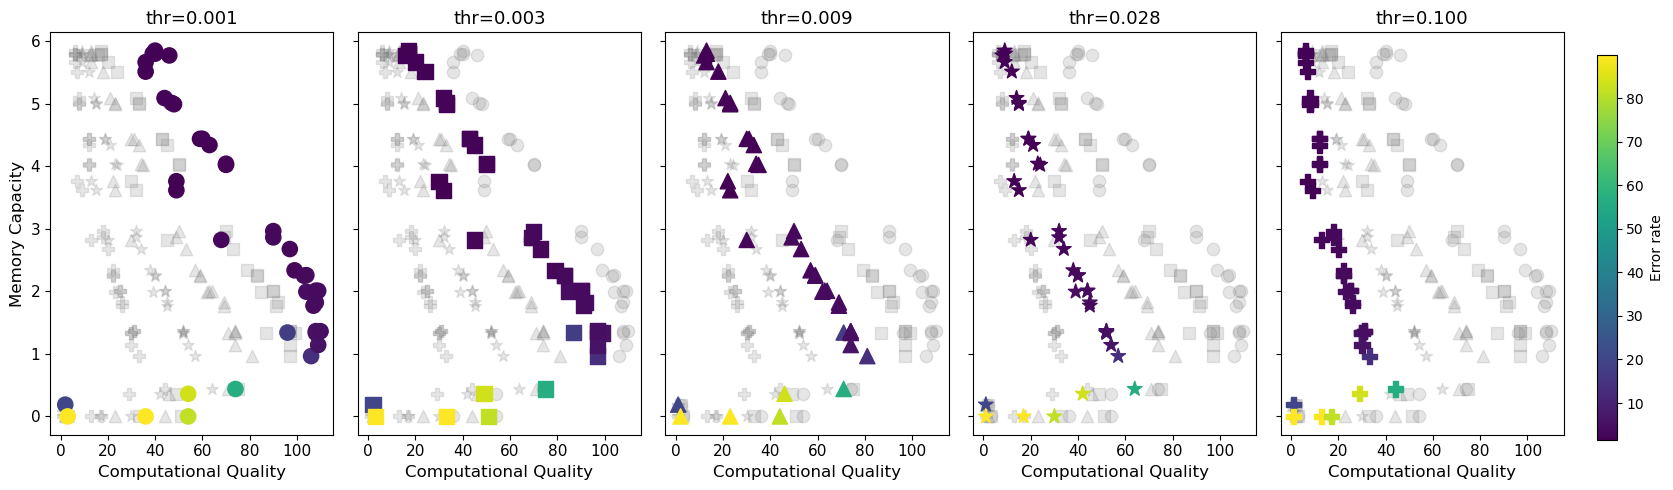

In [64]:
# 将不同threshold的0/1散点图绘制为2*3的子图，最后一个子图用于放colorbar
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
indices = np.linspace(0, len(thresholds) - 1, 5, dtype=int)
selected_thresholds = thresholds[indices]
# 提前设定不同的marker
markers = ['o', 's', '^', '*', 'P']
# 提前设定不同的颜色
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
axes_flat = axes.flatten()
sc = None

for i, (th_cur, marker_cur, color_cur) in enumerate(zip(selected_thresholds, markers, colors)):
    ax = axes_flat[i]
    # 依次画出所有threshold的点，当前th曲线alpha=1，其他alpha=0.2
    # 先画灰色点，再画当前th点确保当前th点在最顶层
    for th_j, marker_j, color_j in zip(selected_thresholds, markers, colors):
        if th_j != th_cur:
            ax.scatter(result[2, th_j]['CQ'], MC, marker=marker_j, s=80, color='gray', alpha=0.2)
    sc = ax.scatter(result[2, th_cur]['CQ'], MC, marker=marker_cur, s=120, c=error_rate, cmap='viridis', alpha=1, label=f'thr={th_cur:.3f}')
    ax.set_title(f'thr={th_cur:.3f}', fontsize=13)
    ax.set_xlabel('Computational Quality', fontsize=12)
    if i == 0:
        ax.set_ylabel('Memory Capacity', fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
# colorbar放在最后一个子图的右边
fig.subplots_adjust(right=1.13)  # 给colorbar留出空间
cbar = fig.colorbar(sc, ax=axes_flat[:-1], location='right', pad=0.03, fraction=0.04, label='Error rate')
plt.tight_layout(rect=[0, 0, 0.88, 1])  # 避免colorbar重叠
plt.show()

C:\Users\Chen\AppData\Local\Temp\ipykernel_9280\3346021098.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


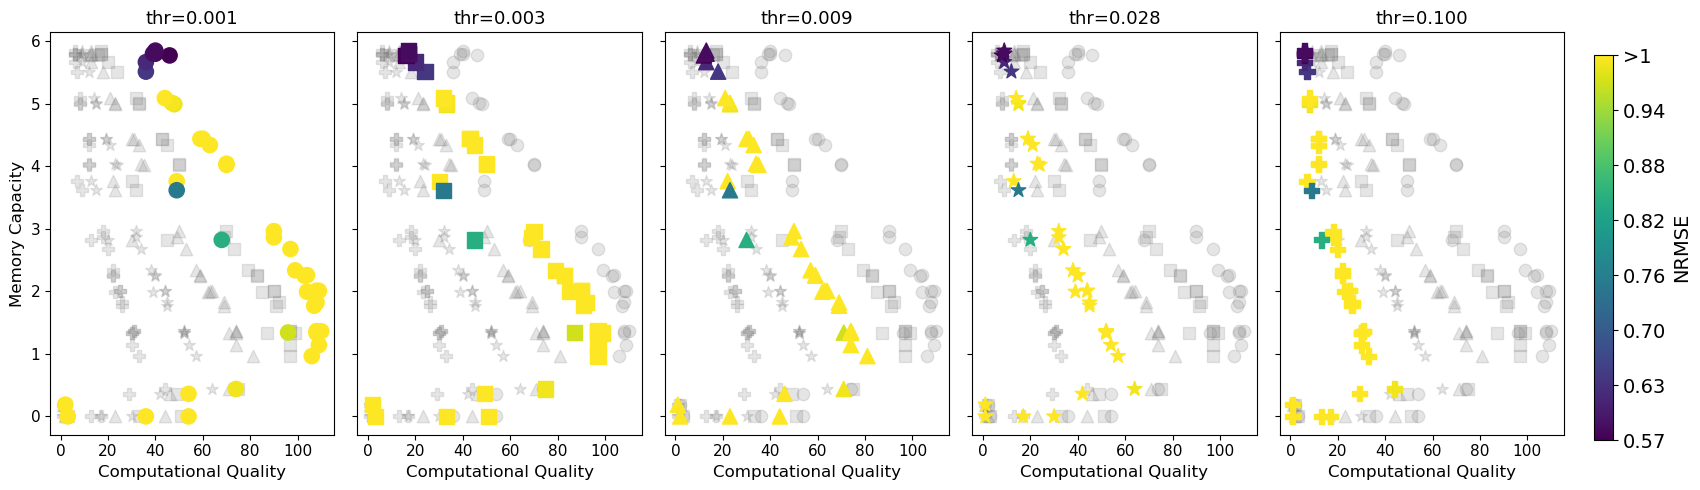

In [65]:
# 设置颜色范围
vmin = nrmse.min()  # NRMSE 通常从 0 开始
vmax = 1.0  # 将 >1 的值统一映射到顶端颜色

# 将不同threshold的散点图绘制为1*5的子图
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
indices = np.linspace(0, len(thresholds) - 1, 5, dtype=int)
selected_thresholds = thresholds[indices]

# 提前设定不同的marker和颜色
markers = ['o', 's', '^', '*', 'P']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
axes_flat = axes.flatten()
sc = None

for i, (th_cur, marker_cur, color_cur) in enumerate(zip(selected_thresholds, markers, colors)):
    ax = axes_flat[i]
    
    # 先画灰色背景点
    for th_j, marker_j, color_j in zip(selected_thresholds, markers, colors):
        if th_j != th_cur:
            ax.scatter(result[2, th_j]['CQ'], MC, marker=marker_j, s=80, color='gray', alpha=0.2)
    
    # 画当前threshold的彩色点，设置 vmin 和 vmax
    sc = ax.scatter(result[2, th_cur]['CQ'], MC, marker=marker_cur, s=120, c=nrmse, 
                    cmap='viridis', alpha=1, vmin=vmin, vmax=vmax, label=f'thr={th_cur:.3f}')
    
    ax.set_title(f'thr={th_cur:.3f}', fontsize=13)
    ax.set_xlabel('Computational Quality', fontsize=12)
    if i == 0:
        ax.set_ylabel('Memory Capacity', fontsize=12)
    ax.tick_params(axis='both', labelsize=11)

# 创建 colorbar
fig.subplots_adjust(right=0.92)
cbar = fig.colorbar(sc, ax=axes_flat, location='right', pad=0.03, fraction=0.04)
cbar.set_label('NRMSE', fontsize=14)
cbar.ax.tick_params(labelsize=14)

n_ticks = 8
tick_positions = np.linspace(vmin, vmax, n_ticks)
tick_labels = [f"{t:.2f}" for t in tick_positions]

# 如果你仍然想把超过1的值显示为 ">1"
if nrmse.max() > 1:
    tick_labels[-1] = ">1"

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

C:\Users\Chen\AppData\Local\Temp\ipykernel_9280\1227896043.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


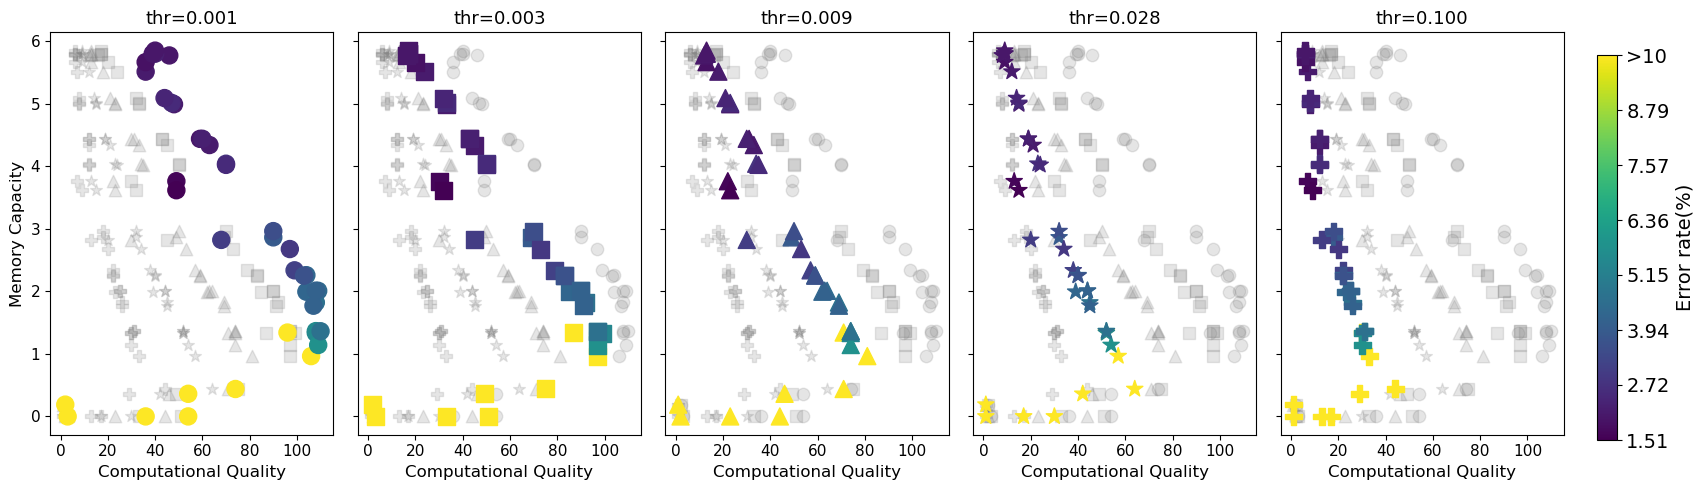

In [66]:
# 使用百分位数来设置颜色范围，避免极端值干扰（推荐方法）
# 将大于10的error rate设置为10，使colorbar顶端为统一颜色
vmin = error_rate.min()   # 第5百分位数
vmax = 10  # colorbar顶端固定为10，所有大于10的error只显示为colorbar顶端同一颜色

# 显示时不直接修改原始数据，但colorbar只到10，超过10将被显示为10对应的颜色
clipped_error_rate = np.clip(error_rate, None, vmax)

# 将不同threshold的散点图绘制为2*3的子图，最后一个子图用于放colorbar
thresholds = np.logspace(np.log10(0.001), np.log10(0.1), 30)
indices = np.linspace(0, len(thresholds) - 1, 5, dtype=int)
selected_thresholds = thresholds[indices]
# 提前设定不同的marker
markers = ['o', 's', '^', '*', 'P']
# 提前设定不同的颜色
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
axes_flat = axes.flatten()
sc = None

for i, (th_cur, marker_cur, color_cur) in enumerate(zip(selected_thresholds, markers, colors)):
    ax = axes_flat[i]
    # 依次画出所有threshold的点，当前th曲线alpha=1，其他alpha=0.2
    # 先画灰色点，再画当前th点确保当前th点在最顶层
    for th_j, marker_j, color_j in zip(selected_thresholds, markers, colors):
        if th_j != th_cur:
            ax.scatter(result[2, th_j]['CQ'], MC, marker=marker_j, s=80, color='gray', alpha=0.2)
    # 使用 vmin 和 vmax 参数限制颜色范围，不修改原始数据
    sc = ax.scatter(result[2, th_cur]['CQ'], MC, marker=marker_cur, s=150, c=error_rate, 
                    cmap='viridis', alpha=1, vmin=vmin, vmax=vmax, label=f'thr={th_cur:.3f}')
    ax.set_title(f'thr={th_cur:.3f}', fontsize=13)
    ax.set_xlabel('Computational Quality', fontsize=12)
    if i == 0:
        ax.set_ylabel('Memory Capacity', fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
# colorbar放在最后一个子图的右边
fig.subplots_adjust(right=1.13)  # 给colorbar留出空间
# 设置colorbar的最大显示数值为10，超过10的部分颜色与10一致
cbar = fig.colorbar(sc, ax=axes_flat[:-1], location='right', pad=0.03, fraction=0.04, label='Error rate(%)')
cbar.set_label('Error rate(%)', fontsize=14)
cbar.ax.tick_params(labelsize=14)

n_ticks = 8
tick_positions = np.linspace(vmin, vmax, n_ticks)
tick_labels = [f"{t:.2f}" for t in tick_positions]

# 如果你仍然想把超过1的值显示为 ">1"
if error_rate.max() > 10:
    tick_labels[-1] = ">10"

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()
